In [1]:
!python -m spacy download en_core_web_lg

^C
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/spacy/__main__.py", line 35, in <module>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torch
import os
import json
import re
import random
from spacy.util import minibatch
from torch import nn
from pytorch_transformers import *
from sklearn.model_selection import train_test_split 
from datetime import datetime as dt
from dateutil import tz

In [2]:
is_using_gpu = spacy.prefer_gpu()
if is_using_gpu:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

nlp = spacy.load('en_pytt_robertabase_lg')
print(nlp.pipe_names) # ["sentencizer", "pytt_wordpiecer", "pytt_tok2vec"]

['sentencizer', 'pytt_wordpiecer', 'pytt_tok2vec']


In [3]:
csv_path = 'dadjokes-subreddit-archive/data_dadjokes.csv'
jokes_path = 'dadjokes-subreddit-archive/data_jokes.csv'

jokes = pd.read_csv(jokes_path, na_values=["[deleted]", "",'N/A'], index_col=0, sep='|')
dj = pd.read_csv(csv_path, na_values=["[deleted]", "",'N/A'], index_col=0, sep='|')
dj.head()

,createdUTC,parent_createdUTC,author,title,selftext,score,num_comments
id,,,,,,,
czh0b5,1567577877,NaN,CMoy1980,Did you know about the Mexican holiday that ce...,It’s called Queso Dia,1,0
czgzij,1567577703,NaN,xjohnnyxleex,"No wonder batteries die, it's gotta hurt to ne...",NaN,1,1
czgr1x,1567576067,NaN,kwagmyre1907,What does the priest of the Vegetable Church say?,Lettuce pray,1,0
czgqyv,1567576046,NaN,wonder-er,Did you hear about the guy who got arrested fo...,He made bale.,1,0
czglpu,1567574996,NaN,DesertRebel,Shot my first turkey last year,Scared the shit out of everyone in the frozen ...,1,0


In [4]:
jokes.head()

,createdUTC,parent_createdUTC,author,title,selftext,score,num_comments
id,,,,,,,
czi77n,1567586974,NaN,brooksy67,Whats the stupidest animal in the jungle?,A polar bear,1,0
czi2nb,1567585886,NaN,The_RockObama,I was teaching my 2 year old son how to drink ...,His mom walks in just to hear me say to him: '...,1,1
czi1pp,1567585656,NaN,wrongdotcom,Mate 1: I love my brown eyed girlfriend,Mate 2: But she has blue eyes\n\nMate 1: Exactly,1,0
czi0t7,1567585443,NaN,redhead_bandit,My mom doesnt want me to play videogames becau...,Well I don't believe her bullshit. I'm light b...,1,0
czi00y,1567585255,NaN,AlphaScar,I Went Traveling Recently...,"...and was shocked to discover that in Aruba, ...",1,1


In [5]:
print(dj.isna().sum())
print(jokes.isna().sum())

createdUTC                0
parent_createdUTC    159592
author                14417
title                     3
selftext              14285
score                     0
num_comments              0
dtype: int64
createdUTC                0
parent_createdUTC    989287
author               168017
title                    25
selftext             112425
score                     0
num_comments              0
dtype: int64


In [6]:
def fill_na(df):
    df.title.fillna('', inplace=True)
    df.selftext.fillna('', inplace=True)
    return df

dj = fill_na(dj)
jokes = fill_na(jokes)
print(dj.isna().sum())
print(jokes.isna().sum())

createdUTC                0
parent_createdUTC    159592
author                14417
title                     0
selftext                  0
score                     0
num_comments              0
dtype: int64
createdUTC                0
parent_createdUTC    989287
author               168017
title                     0
selftext                  0
score                     0
num_comments              0
dtype: int64


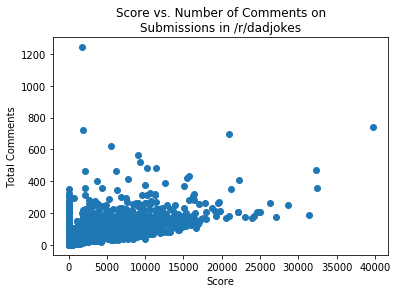

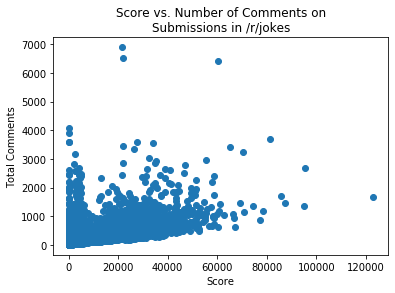

In [7]:
plt.scatter(dj.score, dj.num_comments);
plt.xlabel('Score')
plt.ylabel('Total Comments')
plt.title('Score vs. Number of Comments on\nSubmissions in /r/dadjokes')
plt.show()

plt.scatter(jokes.score, jokes.num_comments);
plt.xlabel('Score')
plt.ylabel('Total Comments')
plt.title('Score vs. Number of Comments on\nSubmissions in /r/jokes')
plt.show()

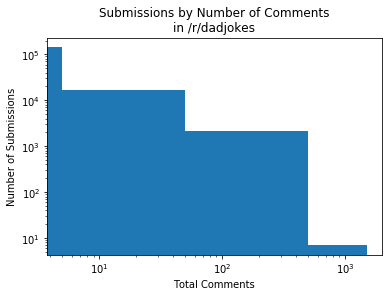

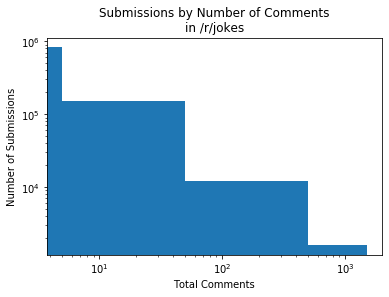

In [19]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Comments')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Number of Comments\nin /r/dadjokes')
plt.hist(dj.num_comments, bins=[0,5,50,500,1500]);
plt.show()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Comments')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Number of Comments\nin /r/jokes')
plt.hist(jokes.num_comments, bins=[0,5,50,500,1500]);
plt.show()

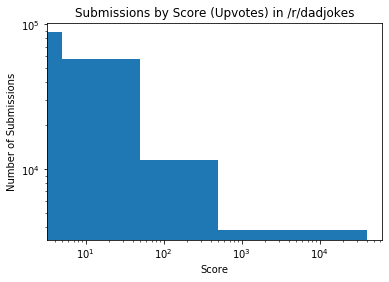

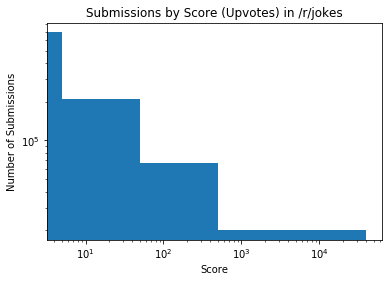

In [16]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Score (Upvotes) in /r/dadjokes')
plt.hist(dj.score, bins=[0,5,50,500,40000]);
plt.show()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Score (Upvotes) in /r/jokes')
plt.hist(jokes.score, bins=[0,5,50,500,40000]);
plt.show()

In [10]:
jokes['is_crosspost'] = ~jokes['parent_createdUTC'].isna()
jokes.groupby(by='is_crosspost').mean()    

,createdUTC,parent_createdUTC,score,num_comments
is_crosspost,,,,
False,1.490987e+09,NaN,104.289937,5.887396
True,1.543290e+09,1.541537e+09,1.002805,0.042076


In [11]:
dj['is_crosspost'] = ~dj['parent_createdUTC'].isna()
dj.groupby(by='is_crosspost').mean()    

,createdUTC,parent_createdUTC,score,num_comments
is_crosspost,,,,
False,1.494472e+09,NaN,91.791305,3.317967
True,1.544440e+09,1.543943e+09,2.568659,0.348950


##### Crossposts receive significantly lower scores, num_comments than original posts in the dadjokes subreddit. This may be because viewers are easily redirected to the parent post to comments or upvote in other areas of reddit. However, the contents of the crossposted jokes (title and selftext) are pulled from the parent posts. Therefore crossposts will be analyzed separately when attempting to predict scores, num_comments.

In [12]:
main_dj = dj[~dj.is_crosspost].drop(columns=['parent_createdUTC', 'is_crosspost'])
print(main_dj.shape)

main_jokes = jokes[~jokes.is_crosspost].drop(columns=['parent_createdUTC', 'is_crosspost'])
print(main_jokes.shape)

(159592, 6)
(989287, 6)


In [13]:
train_dj, test_dj = train_test_split(main_dj, test_size=0.2, random_state=42)
print(f"Training sample size: {len(train_dj)}\nTesting sample size: {len(test_dj)}")

train_jokes, test_jokes = train_test_split(main_jokes, test_size=0.2, random_state=42)
print(f"Training sample size: {len(train_jokes)}\nTesting sample size: {len(test_jokes)}")

Training sample size: 127673
Testing sample size: 31919
Training sample size: 791429
Testing sample size: 197858


In [20]:
def cat_num(val):
    if val <= 5:
        return 0
    elif val <= 50:
        return 1
    elif val <= 500:
        return 2
    else:
        return 3

def make_categories(data):
    data['score_cat'] = data['score'].apply(lambda x: cat_num(x))
    data['comment_cat'] = data['num_comments'].apply(lambda x: cat_num(x))
    return data    


newlines = re.compile(r'(\\n)+')
def _gettext(s):
    s = s.replace('&amp;#x200B;', '')
    s = newlines.sub(' ', s)
    return s


def prepare_text(data):
    data['title_clean'] = data.title.apply(_gettext)
    data['selftext_clean'] = data.selftext.apply(_gettext)
    return data


In [21]:
train_dj = make_categories(train_dj)
train_dj = prepare_text(train_dj)
train_dj.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,createdUTC,author,title,selftext,score,num_comments,score_cat,comment_cat,title_clean,selftext_clean
id,,,,,,,,,,
2l2vef,1414950128,broccolibush42,My dad posted this picture on Facebook. He jus...,http://imgur.com/9M4dGnO\n\nMy dad is notoriou...,1342,41,3,1,My dad posted this picture on Facebook. He jus...,http://imgur.com/9M4dGnO My dad is notoriously...
2gtab2,1411085179,FlawlessBacon,So my dad out-dadjoked me today...,I was having dinner with my family when I reme...,6,0,1,0,So my dad out-dadjoked me today...,I was having dinner with my family when I reme...
7zmvtz,1519378372,NaN,Why did the baker have brown hands?,,1,0,0,0,Why did the baker have brown hands?,
ae0qnm,1546992196,Noeltm,What do you call it when canon ammunition cons...,Canonbalism,1,2,0,0,What do you call it when canon ammunition cons...,Canonbalism
72gkpd,1506384117,ZeLittleMan,I started getting death threats after wearing ...,Apparently there's a Bounty on my head,746,12,3,1,I started getting death threats after wearing ...,Apparently there's a Bounty on my head


In [23]:
def vectorize_jokes(data):
    data['title_vec'] = list(nlp.pipe(data.title_clean))
    data['selftext_vec'] = list(nlp.pipe(data.selftext_clean))
    return data
small = train_dj[:20]
small

,createdUTC,author,title,selftext,score,num_comments,score_cat,comment_cat,title_clean,selftext_clean
id,,,,,,,,,,
2l2vef,1414950128,broccolibush42,My dad posted this picture on Facebook. He jus...,http://imgur.com/9M4dGnO\n\nMy dad is notoriou...,1342,41,3,1,My dad posted this picture on Facebook. He jus...,http://imgur.com/9M4dGnO My dad is notoriously...
2gtab2,1411085179,FlawlessBacon,So my dad out-dadjoked me today...,I was having dinner with my family when I reme...,6,0,1,0,So my dad out-dadjoked me today...,I was having dinner with my family when I reme...
7zmvtz,1519378372,NaN,Why did the baker have brown hands?,,1,0,0,0,Why did the baker have brown hands?,
ae0qnm,1546992196,Noeltm,What do you call it when canon ammunition cons...,Canonbalism,1,2,0,0,What do you call it when canon ammunition cons...,Canonbalism
72gkpd,1506384117,ZeLittleMan,I started getting death threats after wearing ...,Apparently there's a Bounty on my head,746,12,3,1,I started getting death threats after wearing ...,Apparently there's a Bounty on my head
1u7y8v,1388655082,NaN,My dad is a strange man..,My dad is strange\nhttp://i.imgur.com/PT4JYEo.jpg,1,0,0,0,My dad is a strange man..,My dad is strange http://i.imgur.com/PT4JYEo.jpg
9teygu,1541116705,74CK,My uncle needed a blood transplant and before ...,Nothing. He died in his sleep.,1,2,0,0,My uncle needed a blood transplant and before ...,Nothing. He died in his sleep.
1lgoeg,1377960453,aloranor,It's like the dad joke Olympics.,,31,4,1,0,It's like the dad joke Olympics.,
1o9kph,1381544284,catbatmanshe,My dad got to play golf with a Texans punter...,My dad asked if the punter wanted him and the ...,5,0,0,0,My dad got to play golf with a Texans punter...,My dad asked if the punter wanted him and the ...


In [24]:

small = vectorize_jokes(small)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
textcat = nlp.create_pipe("pytt_textcat", config={"exclusive_classes": True})
for label in ("score_cat", "comment_cat"):
    textcat.add_label(label)
nlp.add_pipe(textcat)

optimizer = nlp.resume_training()
for i in range(10):
    random.shuffle(TRAIN_DATA)
    losses = {}
    for batch in minibatch(TRAIN_DATA, size=8):
        texts, cats = zip(*batch)
        nlp.update(texts, cats, sgd=optimizer, losses=losses)
    print(i, losses)
nlp.to_disk("/bert-textcat")


In [25]:
small

,createdUTC,author,title,selftext,score,num_comments,score_cat,comment_cat,title_clean,selftext_clean,title_vec,selftext_vec
id,,,,,,,,,,,,
2l2vef,1414950128,broccolibush42,My dad posted this picture on Facebook. He jus...,http://imgur.com/9M4dGnO\n\nMy dad is notoriou...,1342,41,3,1,My dad posted this picture on Facebook. He jus...,http://imgur.com/9M4dGnO My dad is notoriously...,"(My, dad, posted, this, picture, on, Facebook,...","(http://imgur.com/9M4dGnO, My, dad, is, notori..."
2gtab2,1411085179,FlawlessBacon,So my dad out-dadjoked me today...,I was having dinner with my family when I reme...,6,0,1,0,So my dad out-dadjoked me today...,I was having dinner with my family when I reme...,"(So, my, dad, out, -, dadjoked, me, today, ...)","(I, was, having, dinner, with, my, family, whe..."
7zmvtz,1519378372,NaN,Why did the baker have brown hands?,,1,0,0,0,Why did the baker have brown hands?,,"(Why, did, the, baker, have, brown, hands, ?)",()
ae0qnm,1546992196,Noeltm,What do you call it when canon ammunition cons...,Canonbalism,1,2,0,0,What do you call it when canon ammunition cons...,Canonbalism,"(What, do, you, call, it, when, canon, ammunit...",(Canonbalism)
72gkpd,1506384117,ZeLittleMan,I started getting death threats after wearing ...,Apparently there's a Bounty on my head,746,12,3,1,I started getting death threats after wearing ...,Apparently there's a Bounty on my head,"(I, started, getting, death, threats, after, w...","(Apparently, there, 's, a, Bounty, on, my, head)"
1u7y8v,1388655082,NaN,My dad is a strange man..,My dad is strange\nhttp://i.imgur.com/PT4JYEo.jpg,1,0,0,0,My dad is a strange man..,My dad is strange http://i.imgur.com/PT4JYEo.jpg,"(My, dad, is, a, strange, man, ..)","(My, dad, is, strange, http://i.imgur.com/PT4J..."
9teygu,1541116705,74CK,My uncle needed a blood transplant and before ...,Nothing. He died in his sleep.,1,2,0,0,My uncle needed a blood transplant and before ...,Nothing. He died in his sleep.,"(My, uncle, needed, a, blood, transplant, and,...","(Nothing, ., He, died, in, his, sleep, .)"
1lgoeg,1377960453,aloranor,It's like the dad joke Olympics.,,31,4,1,0,It's like the dad joke Olympics.,,"(It, 's, like, the, dad, joke, Olympics, .)",()
1o9kph,1381544284,catbatmanshe,My dad got to play golf with a Texans punter...,My dad asked if the punter wanted him and the ...,5,0,0,0,My dad got to play golf with a Texans punter...,My dad asked if the punter wanted him and the ...,"(My, dad, got, to, play, golf, with, a, Texans...","(My, dad, asked, if, the, punter, wanted, him,..."
